In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import norm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
def bs_delta(S, K, T, sigma, r=0.0, call=True, eps=1e-8):
    sigma_safe = np.maximum(sigma, eps)
    T_safe = np.maximum(T, eps)
    d1 = (np.log(S / K) + (r + 0.5 * sigma_safe**2) * T_safe) / (sigma_safe * np.sqrt(T_safe))
    return norm.cdf(d1) if call else norm.cdf(d1) - 1

In [19]:
def simulate_heston(n_paths=10000, n_steps=30, dt=1/365):
    S0, V0 = 100, 0.04
    kappa, theta, xi, rho, r = 1.5, 0.04, 0.5, -0.7, 0.0
    np.random.seed(42)
    
    S = np.zeros((n_paths, n_steps + 1))
    V = np.zeros((n_paths, n_steps + 1))
    S[:, 0], V[:, 0] = S0, V0

    for t in range(n_steps):
        z1 = np.random.normal(size=n_paths)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_paths)
        V[:, t+1] = np.maximum(V[:, t] + kappa*(theta - V[:, t])*dt + xi*np.sqrt(V[:, t])*np.sqrt(dt)*z2, 1e-10)
        S[:, t+1] = S[:, t] * np.exp((r - 0.5*V[:, t])*dt + np.sqrt(V[:, t])*np.sqrt(dt)*z1)

    return S, V

In [20]:
def prepare_inputs(S, V, K=100.0, dt=1/365):
    n_paths, n_steps_plus_1 = S.shape
    steps = n_steps_plus_1 - 1
    T_grid = np.linspace(steps*dt, 0, steps)

    logS = np.log(S[:, :-1])
    var = V[:, :-1]
    sigma = np.sqrt(var)
    time = T_grid[None, :]

    delta_bs = bs_delta(S[:, :-1], K, time, sigma)
    X = np.stack([logS, var, delta_bs], axis=-1)  # (n_paths, steps, 3)
    S_diff = S[:, 1:] - S[:, :-1]  # (n_paths, steps)
    return X, S_diff, S[:, -1]

In [21]:
class SimpleHedgeModel(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

In [22]:
def train_model(model, X, S_diff, payoff, alpha=0.5, lr=1e-3, n_epochs=10):
    X = torch.tensor(X, dtype=torch.float32, device=device)
    S_diff = torch.tensor(S_diff, dtype=torch.float32, device=device)
    payoff = torch.tensor(payoff, dtype=torch.float32, device=device)
    
    model.to(device)
    model.train()

    p0 = torch.tensor([0.0], requires_grad=True, device=device)
    opt = torch.optim.Adam(list(model.parameters()) + [p0], lr=lr)

    losses = []
    for epoch in range(n_epochs):
        hedge = model(X).squeeze(-1)  # (n_paths, steps)
        gains = torch.sum(hedge * S_diff, dim=1)  # (n_paths,)
        pnl = p0 - payoff + gains
        loss = cvar_loss(pnl, alpha)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return p0.item(), losses, pnl.detach().cpu().numpy()

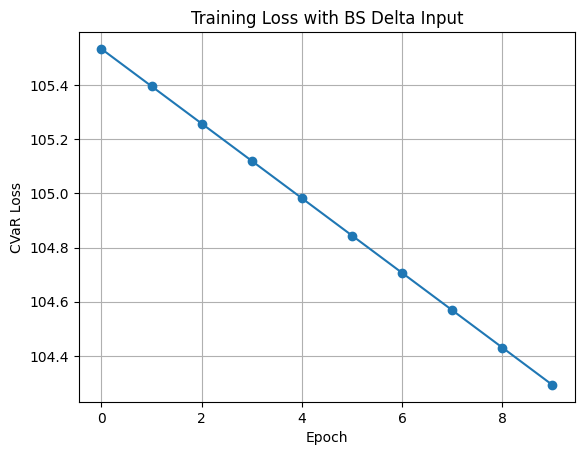

In [25]:
# Simulate paths
S, V = simulate_heston(n_paths=10000, n_steps=30)
X, S_diff, payoff = prepare_inputs(S, V)
model = SimpleHedgeModel(in_dim=3)

# Train
q, losses, pnl = train_model(model, X, S_diff, payoff, alpha=0.5)

# Plot
plt.plot(losses, marker='o')
plt.title("Training Loss with BS Delta Input")
plt.xlabel("Epoch")
plt.ylabel("CVaR Loss")
plt.grid()
plt.show()

In [26]:
def compute_metrics(pnl_array, p0):
    mean_pnl = np.mean(pnl_array)
    std_pnl = np.std(pnl_array)
    mshe = np.mean(np.square(pnl_array))

    def cvar(pnl, alpha=0.5):
        X = -pnl
        w = np.quantile(X, alpha)
        return -(w + (1.0 / (1.0 - alpha)) * np.mean(np.maximum(X - w, 0)))

    cvar_50 = cvar(pnl_array, alpha=0.5)
    cvar_99 = cvar(pnl_array, alpha=0.99)

    return {
        "Mean PnL": mean_pnl,
        "Std PnL": std_pnl,
        "MSHE": mshe,
        "CVaR (0.5)": cvar_50,
        "CVaR (0.99)": cvar_99,
        "Price (q)": p0
    }

In [28]:
def prepare_inputs_baseline(S, V):
    logS = np.log(S[:, :-1])
    var = V[:, :-1]
    X = np.stack([logS, var], axis=-1)  # (n_paths, steps, 2)
    S_diff = S[:, 1:] - S[:, :-1]       # (n_paths, steps)
    return X, S_diff, S[:, -1]

In [29]:
# Prepare data
X_base, S_diff_base, payoff_base = prepare_inputs_baseline(S, V)

# Define model
model_base = SimpleHedgeModel(in_dim=2)

# Train
q_base, losses_base, pnl_base = train_model(model_base, X_base, S_diff_base, payoff_base, alpha=0.5)

In [30]:
metrics_base = compute_metrics(pnl_base, q_base)

In [32]:
metrics_base = compute_metrics(pnl_base, q_base)
metrics_bs = compute_metrics(pnl, q)

In [36]:
import pandas as pd

# Combine metrics into a DataFrame
metrics_table = pd.DataFrame({
    "Metric": metrics_base.keys(),
    "Without BS Delta": metrics_base.values(),
    "With BS Delta": metrics_bs.values()
})

# Display the table
print(metrics_table)

        Metric  Without BS Delta  With BS Delta
0     Mean PnL        -99.931488     -99.955811
1      Std PnL          9.886166       5.474132
2         MSHE      10084.040039   10021.130859
3   CVaR (0.5)       -107.709502    -104.293149
4  CVaR (0.99)       -122.559420    -112.986701
5    Price (q)          0.010000       0.010000


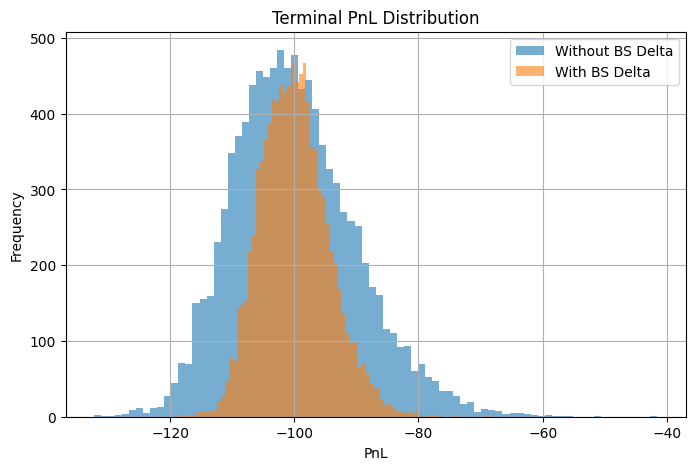

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(pnl_base, bins=80, alpha=0.6, label="Without BS Delta")
plt.hist(pnl, bins=80, alpha=0.6, label="With BS Delta")
plt.title("Terminal PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()